**Overview**<br>
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

We will be using the online reatil trasnational dataset to build a RFM clustering and choose the best set of customers.

In [1]:
#Importing Libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
#reading Dataset
df1 = pd.read_csv("Online_Retail.csv",encoding = "ISO-8859-1")
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### Convert InvoiceDate to date format

In [4]:
df1["InvoiceDate"]=pd.to_datetime(df1["InvoiceDate"],format="%d-%m-%Y %H:%M")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
## Check nulll records
df1.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df1.shape

(541909, 8)

Now, as you can notice, the data set is at the granularity of order level. So, it doesn’t make much sense to do missing value imputation because it would be very difficult to predict the individual missing details of individual orders. Hence, you have to remove the entries with the missing values.

### What Does Granular Data Mean?
Granular data is detailed data, or the lowest level that data can be in a target set. It refers to the size that data fields are divided into, in short how detail-oriented a single field is. A good example of data granularity is how a name field is subdivided, if it is contained in a single field or subdivided into its constituents such as first name, middle name and last name. As the data becomes more subdivided and specific, it is also considered more granular.

In [7]:
df=df1.dropna()

In [8]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
df.shape

(406829, 8)

**Our main objective is to cluster the customers of the online store. So, you need to transform this order-wise data into customer-wise data by finding key attributes that best characterises a customer. This is achieved through RFM analysis.**

### RFM analysis

In RFM analysis, you look at the recency, frequency and the monetary scores of all the customers for segmentation.

`Recency`: It measures how recently you visited the store or made a purchase

`Frequency`: It measures the frequency of the transactions the customers made

`Monetary`: It measures how much the customer spent on purchases he/she made

1. So, your target is to compute the RFM numbers for each customer, which effectively means that the granularity level of your data set will change from Invoice number to the CustomerID. Thus, you will have one unique row corresponding to each customer.
2. Let’s start with creating customer-wise data. We begin with the computation of M of the RFM, that is the total monetary value of the purchases made by each customer
3. Create a vector named Amount, which creates the total monetary value of each order, and append the column to your data set.

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [11]:
amount=pd.DataFrame(df["Quantity"] * df["UnitPrice"],columns=["Amount"])
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


**Sort the data set in order of CustomerID. Next, create a new vector — monetary — which gives the aggregated purchase amount for each customer.**

In [12]:
df=pd.concat([df,amount],axis=1,ignore_index=False)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [13]:
monetary=df.groupby("CustomerID")["Amount"].sum().reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


#### This data frame monetary is the M of the RFM framework.
Next, let’s compute the frequency of purchase for each customer, i.e. the F of the RFM framework. For this, you will count the number of unique Invoice Numbers for each Customer ID.  This is the “Frequency” corresponding to each customer.m

In [14]:
#Frequency function
frequency=df.groupby("CustomerID")["InvoiceNo"].count().reset_index()
frequency.rename(columns={"InvoiceNo": "Frequency"},inplace=True)
frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [15]:
# Merge monetary and frequency
master =pd.merge(monetary,frequency,on="CustomerID",how="inner")
master.head() 

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


1. Thus, the data frame master contains both the monetary and the frequency attributes corresponding to each customer IDs. Now, you have to turn your attention towards the computation of the recency, i.e. for how long a customer has not visited the online store.
2. Begin by extracting the Customer ID and Invoice Date from the data. Now, find the latest “Invoice Date” which forms the reference point for the calculation of the “Recency” of each customer. For each order corresponding to each customer, you find the difference from the latest “Invoice Date” and then find the minimum “Recency” value for each customer

In [16]:
#Generating recency function
recency  = df[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head()

E:\Software_install\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


**1. Day(d) and DateOffset(days=d) do not behave exactly the same when used on timestamps with timezone information (at least on pandas 0.18.0). It looks like DateOffset add 1 day while keeping the hour information while Day adds just 24 hours of elapsed time.**

**2. Look at the below one: "day" resets the actual day, "days" adds to the original day.**

pd.Timestamp("2019-12-25") + pd.DateOffset(day=1)

Timestamp('2019-12-01 00:00:00')

pd.Timestamp("2019-12-25") + pd.DateOffset(days=1)

Timestamp('2019-12-26 00:00:00')



In [17]:
#Dataframe merging by recency
df2 = pd.DataFrame(recency.groupby('CustomerID')["diff"].min().reset_index())
df2.columns = ["CustomerID", "Recency"]
df2.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


### Now, the data frame recency contains the recency for each customer. Let’s merge it to the RFM data set and change the format to the required form.

 

## RFM combined dataset

In [18]:
#Combining all recency, frequency and monetary parameters
RFM = frequency.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df2, on = "CustomerID")
RFM

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
...,...,...,...,...
4367,18280.0,10,180.60,278 days 02:58:00
4368,18281.0,7,80.82,181 days 01:57:00
4369,18282.0,13,176.60,8 days 01:07:00
4370,18283.0,756,2094.88,4 days 00:48:00


# Outlier Treatment

**However, your data preparation is still not complete. You have already seen previously how the clustering process can be impacted due to the presence of outliers. So, let’s treat the data set for outliers. One way to do it is by eliminating all the data points which fall outside the 1.5 times the IQR of the 1st and the 3rd quartile.**

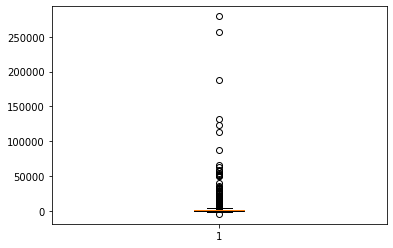

In [19]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

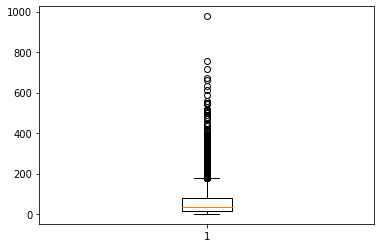

In [20]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

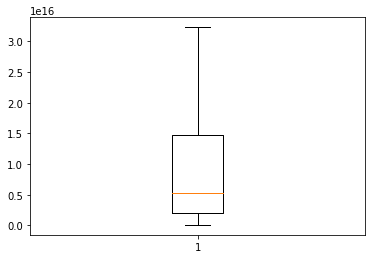

In [21]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [22]:
RFM.shape

(3697, 4)

### Standardize the data

In [23]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [24]:
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00


In [25]:
RFM_1=RFM.drop("CustomerID",axis=1)
RFM_1.head()

,Frequency,Amount,Recency
0,2,0.00,326 days 02:33:00
2,31,1797.24,75 days 23:37:00
3,73,1757.55,19 days 02:59:00
4,17,334.40,310 days 20:49:00
5,95,1545.41,36 days 22:13:00


In [26]:
# converts 326 days 02:33:00 format to numeric format
RFM_1.Recency=RFM_1.Recency.dt.days
RFM_1

,Frequency,Amount,Recency
0,2,0.00,326
2,31,1797.24,75
3,73,1757.55,19
4,17,334.40,310
5,95,1545.41,36
...,...,...,...
4366,9,173.90,74
4367,10,180.60,278
4368,7,80.82,181
4369,13,176.60,8


In [27]:
scale=scaler.fit_transform(RFM_1)
scale

array([[-1.07094871, -1.04161396,  2.13642223],
       [-0.3754979 ,  1.38529792, -0.28204953],
       [ 0.63170672,  1.33170234, -0.82162889],
       ...,
       [-0.9510434 , -0.93247827,  0.73929711],
       [-0.80715703, -0.80314128, -0.92761769],
       [ 0.55976353,  1.43936613, -0.59038059]])

In [28]:
RFM_1=pd.DataFrame(scale)
RFM_1.rename(columns={0:"Frequency",1:"Amount",2:"Recency"},inplace=True)
RFM_1

,Frequency,Amount,Recency
0,-1.070949,-1.041614,2.136422
1,-0.375498,1.385298,-0.282050
2,0.631707,1.331702,-0.821629
3,-0.711233,-0.590055,1.982257
4,1.159290,1.045238,-0.657828
...,...,...,...
3692,-0.903081,-0.806787,-0.291685
3693,-0.879100,-0.797740,1.673926
3694,-0.951043,-0.932478,0.739297
3695,-0.807157,-0.803141,-0.927618


### Here, let's try to understand the different parameters from Scikit Learn Documentation:

1. n_clusters: The number of clusters to form as well as the number of centroids to generate
2. init: Method for initialization of the cluster centres
3. n_init: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the 

best output of n_init consecutive runs in terms of inertia (explained below).
1. max_iter: Maximum number of iterations of the k-means algorithm for a single run in case it doesn't converge on its own

### Let's now try to understand the output of the KMeans() function.
1. cluster_centers: Coordinates of cluster centres
2. labels: Labels of each point i.e. the labels to which the points belong
3. inertia: Sum of squared distances of points to their closest cluster centre

## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

Some usefull links to understand Hopkins Statistics:
- [WikiPedia](https://en.wikipedia.org/wiki/Hopkins_statistic)
- [Article](http://www.sthda.com/english/articles/29-cluster-validation-essentials/95-assessing-clustering-tendency-essentials/)

In [29]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [30]:
hopkins(RFM_1)

0.8905093321182848

## Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [31]:
from sklearn.metrics import silhouette_score
sse=[]
for k in range(2,15):
    kmeans=KMeans(n_clusters=k).fit(RFM_1)
    sse.append([k,silhouette_score(RFM_1,kmeans.labels_)])

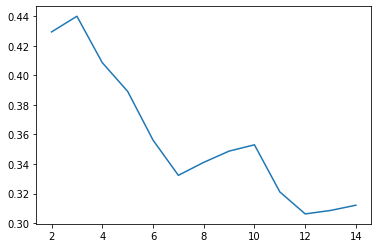

In [32]:
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1]);

#### Observation
Here the value ok k is 3 at max

### Sum of Squared Distances(Elbow Meatod) WCSS/INERTIA

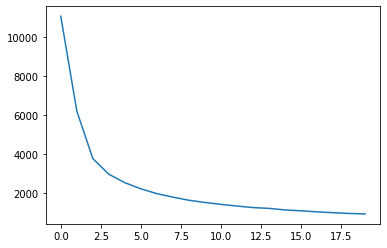

In [33]:
# sum of squared distances
ssd = []
for cluster in list(range(1,21)):
    model_clus=KMeans(n_clusters=cluster,max_iter=50)
    model_clus.fit(RFM_1)
    ssd.append(model_clus.inertia_)
plt.plot(ssd)    

## Ideal K is 3 in this case from elbow and siloutte score

# K-Means with 5 clusers


In [34]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters=5,max_iter=50)
model_clus5.fit(RFM_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [35]:
model_clus5.labels_

array([2, 3, 3, ..., 2, 0, 3])

In [36]:
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00


In [37]:
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']
RFM_km.head()

,CustomerID,Frequency,Amount,Recency,ClusterID
0,12346.0,2.0,0.00,326 days 02:33:00,2.0
1,NaN,NaN,NaN,NaT,3.0
2,12348.0,31.0,1797.24,75 days 23:37:00,3.0
3,12349.0,73.0,1757.55,19 days 02:59:00,2.0
4,12350.0,17.0,334.40,310 days 20:49:00,1.0


In [38]:
RFM_km.Recency=RFM_km.Recency.dt.days
km_clusters_amount=pd.DataFrame(RFM_km.groupby("ClusterID")["Amount"].mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby("ClusterID")["Frequency"].mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby("ClusterID")["Recency"].mean())

In [39]:
df_nw=pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df_nw.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df_nw.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0.0,0,777.974576,46.859389,100.773799
1.0,1,727.291513,44.271812,106.734899
2.0,2,820.690196,48.319481,102.735065
3.0,3,765.557405,46.185497,102.500843
4.0,4,797.281191,49.125000,113.446875


**For Amount_mean**

<AxesSubplot:xlabel='ClusterID', ylabel='Amount_mean'>

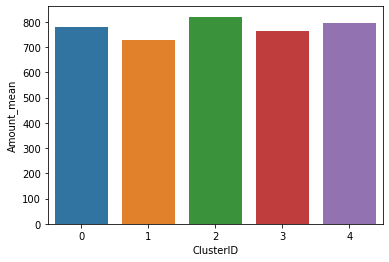

In [40]:
sns.barplot(x=df_nw.ClusterID, y=df_nw.Amount_mean)


#### Here this cluster consist of persons who purchase in high amount among cluster{0,1,2,3,4}

**For Frequency_mean**

<AxesSubplot:xlabel='ClusterID', ylabel='Frequency_mean'>

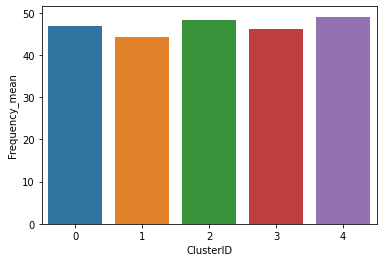

In [41]:
sns.barplot(x=df_nw.ClusterID, y=df_nw.Frequency_mean)

**For Recency_mean**

<AxesSubplot:xlabel='ClusterID', ylabel='Recency_mean'>

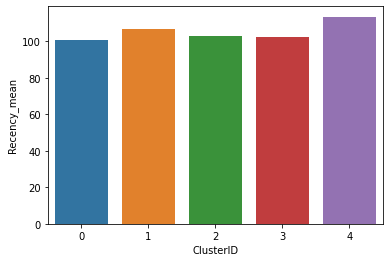

In [42]:
sns.barplot(x=df_nw.ClusterID, y=df_nw.Recency_mean)

You found that cluster 5 was the best customer segment from the store’s point of view. These customers make a purchase for a higher amount, more frequently, and these customers had visited the site recently. Thus, the store may offer them a reward or loyalty points or some privileged status, to keep them attracted and coming back to the store.

# Heirarchical Clustering

In [43]:
# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree

**Single Linkage**

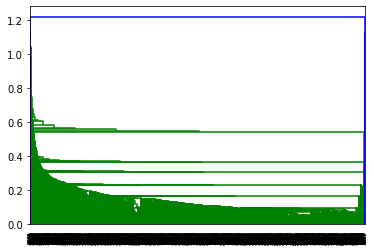

In [44]:
#heirarchical clustering
mergings =linkage(RFM_1,method="single",metric="euclidean")
dendrogram(mergings)
plt.show()

**Complete Linkage**

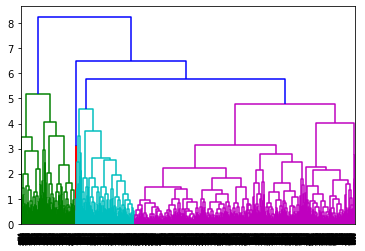

In [45]:
mergings=linkage(RFM_1,method="complete",metric="euclidean")
dendrogram(mergings)
plt.show()

**Average Linkage**

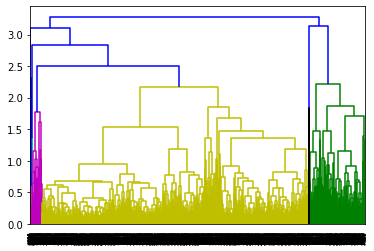

In [46]:
avg_mge=linkage(RFM_1,method="average",metric="euclidean")
dendrogram(avg_mge)
plt.show()

## Lets go with complete Linkeage taking no of clusters=5

In [47]:
cut_tree(mergings,n_clusters=5)

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [48]:
pd.Series(cut_tree(mergings,n_clusters=5).reshape(-1,))

0       0
1       1
2       1
3       0
4       2
       ..
3692    0
3693    0
3694    0
3695    0
3696    1
Length: 3697, dtype: int32

In [49]:
RFM

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00
...,...,...,...,...
4366,18278.0,9,173.90,74 days 00:52:00
4367,18280.0,10,180.60,278 days 02:58:00
4368,18281.0,7,80.82,181 days 01:57:00
4369,18282.0,13,176.60,8 days 01:07:00


In [50]:
RFM=RFM.reset_index()
RFM.drop("index",axis=1,inplace=True)
RFM

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12348.0,31,1797.24,75 days 23:37:00
2,12349.0,73,1757.55,19 days 02:59:00
3,12350.0,17,334.40,310 days 20:49:00
4,12352.0,95,1545.41,36 days 22:13:00
...,...,...,...,...
3692,18278.0,9,173.90,74 days 00:52:00
3693,18280.0,10,180.60,278 days 02:58:00
3694,18281.0,7,80.82,181 days 01:57:00
3695,18282.0,13,176.60,8 days 01:07:00


In [51]:
cluster_cut=pd.Series(cut_tree(mergings,n_clusters=5).reshape(-1,))
hc_rfm=pd.concat([RFM,cluster_cut],axis=1)
hc_rfm.columns=['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']
hc_rfm            

,CustomerID,Frequency,Amount,Recency,ClusterID
0,12346.0,2,0.00,326 days 02:33:00,0
1,12348.0,31,1797.24,75 days 23:37:00,1
2,12349.0,73,1757.55,19 days 02:59:00,1
3,12350.0,17,334.40,310 days 20:49:00,0
4,12352.0,95,1545.41,36 days 22:13:00,2
...,...,...,...,...,...
3692,18278.0,9,173.90,74 days 00:52:00,0
3693,18280.0,10,180.60,278 days 02:58:00,0
3694,18281.0,7,80.82,181 days 01:57:00,0
3695,18282.0,13,176.60,8 days 01:07:00,0


## Sumarise

In [52]:
hc_rfm.Recency=hc_rfm.Recency.dt.days
km_clusters_amount=pd.DataFrame(hc_rfm.groupby("ClusterID")["Amount"].mean())
km_clusters_frequency = pd.DataFrame(hc_rfm.groupby("ClusterID")["Frequency"].mean())
km_clusters_recency = pd.DataFrame(hc_rfm.groupby("ClusterID")["Recency"].mean())

In [53]:
df_nw = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df_nw.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df_nw.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,401.831170,23.929069,131.066011
1,1,1787.153319,44.943966,38.547414
2,2,2324.569366,122.145889,34.856764
3,3,915.359751,89.739875,65.752336
4,4,-997.147143,6.142857,218.285714


<AxesSubplot:xlabel='ClusterID', ylabel='Amount_mean'>

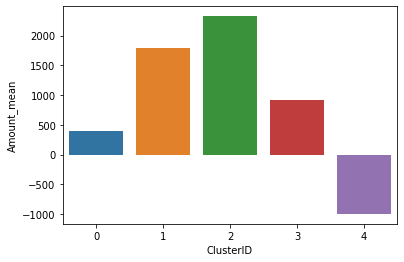

In [54]:
#plotting barplot
sns.barplot(x=df_nw.ClusterID, y=df_nw.Amount_mean)

#### here group no 5 have amount in negative

<AxesSubplot:xlabel='ClusterID', ylabel='Frequency_mean'>

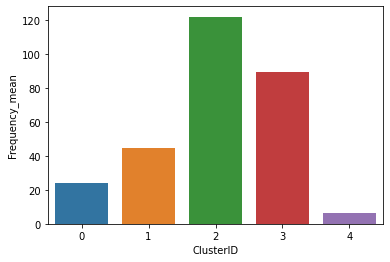

In [55]:
sns.barplot(x=df_nw.ClusterID, y=df_nw.Frequency_mean)

#### here group no 5 have less frequency to buy anything

<AxesSubplot:xlabel='ClusterID', ylabel='Recency_mean'>

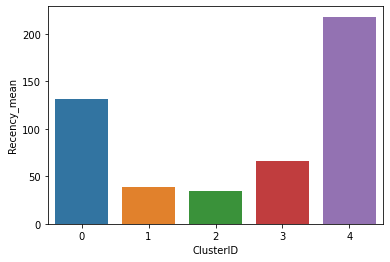

In [56]:
sns.barplot(x=df_nw.ClusterID, y=df_nw.Recency_mean)

#### here group no 5 have less frequency to visit
